# RSS

In [1]:
import feedparser
from datetime import datetime

DATA_PATH='/home/bkadmin/datasets/spatialedge-hackathon-H1/v1/' 
FROM_DATE='20200101'
TO_DATE='20221231'
SYMBOL = 'EURUSD'
TIMEFRAME = 'H1'

### Pull feed from google News

In [2]:
# feed = feedparser.parse("https://news.google.com/rss/search?q=central+bank+US+EU+site%3Abloomberg.com+when%3A1d&hl=en-ZA&gl=ZA&ceid=ZA%3Aen")

# feed2 = feedparser.parse("https://news.google.com/rss/topics/CAAqJggKIiBDQkFTRWdvSUwyMHZNRGx6TVdZU0FtVnVHZ0pWVXlnQVAB/sections/CAQiSENCQVNNQW9JTDIwdk1EbHpNV1lTQW1WdUdnSlZVeUlQQ0FRYUN3b0pMMjB2TUdkbWNITXpLZ3NTQ1M5dEx6Qm5abkJ6TXlnQSoqCAAqJggKIiBDQkFTRWdvSUwyMHZNRGx6TVdZU0FtVnVHZ0pWVXlnQVABUAE?hl=en-US&gl=US&ceid=US%3Aen")

# feed3 = feedparser.parse("https://news.google.com/rss/search?q=EU+Europe+when%3A1y+-War+-Cut+-Cuts+-Low&hl=en-ZA&gl=ZA&ceid=ZA%3Aen")

feeds = ["https://news.google.com/rss/search?q=central+bank+US+EU+site%3Abloomberg.com+when%3A1d&hl=en-ZA&gl=ZA&ceid=ZA%3Aen",
         "https://news.google.com/rss/topics/CAAqJggKIiBDQkFTRWdvSUwyMHZNRGx6TVdZU0FtVnVHZ0pWVXlnQVAB/sections/CAQiSENCQVNNQW9JTDIwdk1EbHpNV1lTQW1WdUdnSlZVeUlQQ0FRYUN3b0pMMjB2TUdkbWNITXpLZ3NTQ1M5dEx6Qm5abkJ6TXlnQSoqCAAqJggKIiBDQkFTRWdvSUwyMHZNRGx6TVdZU0FtVnVHZ0pWVXlnQVABUAE?hl=en-US&gl=US&ceid=US%3Aen",
         "https://news.google.com/rss/search?q=EU+Europe+when%3A1y+-War+-Cut+-Cuts+-Low&hl=en-ZA&gl=ZA&ceid=ZA%3Aen"]

### Exstract Titles and publish dates

In [3]:
titles = []
dates = []

for feed in feeds:
    for post in feedparser.parse(feed).entries:
        title = post.title
        date = post.published
        titles.append(title.replace(' - Bloomberg', ''))
        dates.append(datetime.strptime(date, '%a, %d %b %Y %X %Z').date())

print('Number of RSS posts :', len(titles))

Number of RSS posts : 269


### Exstract tags from titles

In [4]:
if SYMBOL == 'EURUSD':
    search = ['US','U.S.' 'EU', 'Europe']
else:
    search = []

tags_in_title = []
for title in titles:
    tags = []
    for tag in search:
        if tag.lower() in title.lower(): tags+=[tag]
    tags_in_title += [tags]

print(tags_in_title)

[[], ['US'], ['Europe'], ['US'], [], [], [], [], [], [], [], ['US'], [], [], [], ['US'], ['US'], [], ['US'], ['US'], [], [], [], ['US'], ['US'], [], ['US'], [], ['US'], [], [], [], [], [], ['US'], ['Europe'], [], [], [], [], ['US', 'Europe'], [], ['US'], [], ['US'], [], [], ['US'], [], [], ['US'], [], ['US'], ['US'], [], [], ['US'], ['US'], [], [], [], ['US'], ['US'], [], [], [], [], ['US'], [], ['US'], [], [], [], [], [], ['US'], [], [], [], [], [], [], [], [], ['US'], [], [], [], [], [], [], ['US'], ['US'], [], ['US'], [], ['US'], [], [], [], ['US'], [], [], ['US'], ['US'], ['US'], ['US'], [], [], [], ['US', 'Europe'], [], ['US'], [], [], [], [], [], ['US'], [], [], [], [], [], [], [], [], ['US'], [], ['US'], ['US'], ['US'], [], [], [], [], [], [], [], [], ['US'], ['US'], ['US'], ['US'], ['US'], [], [], [], [], ['US'], [], ['US'], [], [], [], [], [], ['US'], [], ['US'], [], [], ['US'], [], [], ['US'], [], [], [], [], ['Europe'], [], ['US'], [], ['Europe'], [], ['Europe'], ['Europe'],

### Create Dataframe

In [5]:
import pandas as pd

df = pd.DataFrame({'Title': titles,'Tags': tags_in_title,'Date': pd.to_datetime(dates)})

df.info()
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Title   269 non-null    object        
 1   Tags    269 non-null    object        
 2   Date    269 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 6.4+ KB
                                                 Title      Tags       Date
0    EU Migration: Macron, Scholz, Orban, Sunak Fig...        [] 2023-10-06
1    Larry Summers Says Fed's Rate Hikes May Not Be...      [US] 2023-10-06
2    BYD to Stick to Europe Growth Plans Despite Su...  [Europe] 2023-10-07
3    Treasuries Tumble as US Payroll Growth Blows P...      [US] 2023-10-06
4    Turkey Vows to Build Reserves as IMF Sees Slow...        [] 2023-10-07
..                                                 ...       ...        ...
264              G20 Session III - European Commission  [Europe] 2023-09-10
265  Euro

## Model

#### Import training dataset

In [6]:
DATASETS = '~/datasets/sentiment_economy_news/'

train = pd.read_parquet(DATASETS + 'train.parquet', engine='pyarrow')
test  = pd.read_parquet(DATASETS + 'test.parquet', engine='pyarrow')

print(train.tail())
print(train.info())

print(test.tail())
print(test.info())

                                                   text    labels  \
2995  'Derogatory' Files Ended Service Of 383 U. S. ...  negative   
2996  Treasury Securities Are Becalmed: Investors Aw...  negative   
2997  SENATE TEST WON BY RIGHTS FORCES: PANEL VOTES ...  negative   
2998  FARMERS PUNISHED IN WETBACK' DRIVE: SOME PERMI...  negative   
2999  EXECUTIVE HIRING EXPECTED TO RISE: STUDY SHOWS...  positive   

          articleid relevance positivity  split positivity_rounded   idx  
2995  nyt_113139986       yes        2.0  train                2.0  2995  
2996  nyt_108972463       yes        4.0  train                4.0  2996  
2997  nyt_119217245       yes        4.0  train                4.0  2997  
2998  nyt_112200942       yes        4.0  train                4.0  2998  
2999  nyt_119481498       yes        6.5  train                6.0  2999  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column              Non-

#### Create a classifier model

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

X_train = train['text']
X_test = test['text']

Y_train = pd.Categorical(train['labels'])
Y_test = pd.Categorical(test['labels'])
labels = Y_train.categories

vectorizer = CountVectorizer()

X_train_tokens = vectorizer.fit_transform(train["text"])

transformer = TfidfTransformer()

X_train_tf = transformer.fit_transform(X_train_tokens)

#title_clf = GaussianNB().fit(X_train_tf.toarray(), Y_train)

#title_clf = Pipeline([
#    ('vect', CountVectorizer()),
#    ('tfidf', TfidfTransformer()),
#    ('clf', GaussianNB()),
#])

#### Train model

In [8]:
title_clf = GaussianNB().fit(X_train_tf.toarray(), Y_train)

#### Evaluate Model

In [9]:

from sklearn.metrics import classification_report

X_test_tokens = vectorizer.transform(test['text'])
X_test_tf = transformer.transform(X_test_tokens)

predicted = title_clf.predict(X_test_tf.toarray())

print(classification_report(Y_test, predicted, target_names=labels))

              precision    recall  f1-score   support

    negative       0.62      0.78      0.69       241
    positive       0.34      0.19      0.24       141

    accuracy                           0.56       382
   macro avg       0.48      0.49      0.47       382
weighted avg       0.52      0.56      0.53       382



#### Plot a bar chart on predicted labels for testing data

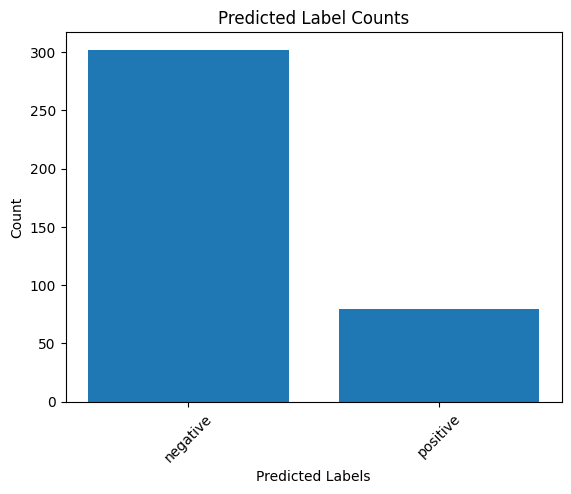

In [10]:
import matplotlib.pyplot as plt 
from collections import Counter

label_counts = Counter(predicted)

# Extract labels and counts as separate lists
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Create a bar chart
plt.bar(labels, counts)
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Predicted Label Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

## Evaluate model on aggregated news sources

                                                 Title      Tags       Date  \
0    EU Migration: Macron, Scholz, Orban, Sunak Fig...        [] 2023-10-06   
1    Larry Summers Says Fed's Rate Hikes May Not Be...      [US] 2023-10-06   
2    BYD to Stick to Europe Growth Plans Despite Su...  [Europe] 2023-10-07   
3    Treasuries Tumble as US Payroll Growth Blows P...      [US] 2023-10-06   
4    Turkey Vows to Build Reserves as IMF Sees Slow...        [] 2023-10-07   
..                                                 ...       ...        ...   
264              G20 Session III - European Commission  [Europe] 2023-09-10   
265  European think tank calls for mandatory EU alc...  [Europe] 2023-09-18   
266  CAPS-EU: Building Capacity for Private Sponsor...        [] 2023-09-16   
267  EU climate commissioner: MEPs mull rejecting n...        [] 2023-09-12   
268  Horizon Europe grants €166m to boost EU space ...  [Europe] 2023-09-08   

       labels  
0    negative  
1    positive  
2  

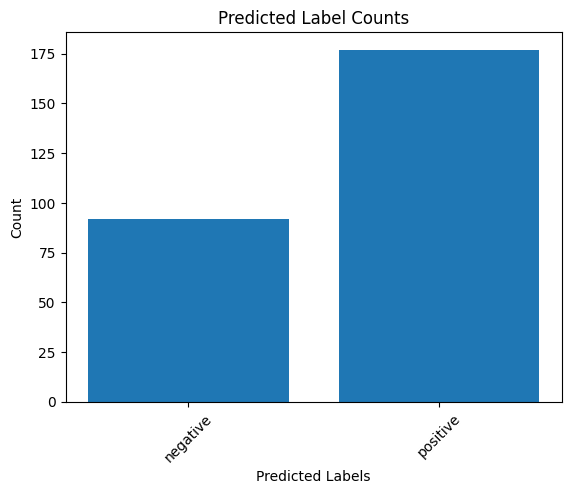

In [15]:
X_titles = df['Title']

X_titles_tokens = vectorizer.transform(X_titles)
X_titles_tf = transformer.transform(X_titles_tokens)

Y_predict = title_clf.predict(X_titles_tf.toarray())

df['labels'] = Y_predict

print(df)

label_counts = Counter(Y_predict)

# Extract labels and counts as separate lists
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Create a bar chart
plt.bar(labels, counts)
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Predicted Label Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()